Set Environment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset

from torcheval.metrics.functional import multiclass_accuracy, multiclass_f1_score

Set Data Image

In [2]:
data_dir = './dataset'

transform = v2.Compose([
    v2.ToImage(),
    v2.Resize((224, 224)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(10),
    v2.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
    v2.RandomAffine(degrees=5, translate=(0.1, 0.1)),
    v2.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = ImageFolder(root=data_dir, transform=transform)

In [3]:
train_ds, val_ds, test_ds = random_split(dataset, [0.7, 0.2, 0.1])

print(f"Train set: {len(train_ds)} samples")
print(f"Valid set: {len(val_ds)} samples")
print(f"Test set: {len(test_ds)} samples")
print(f"Classes: {dataset.classes}")

Train set: 29256 samples
Valid set: 8358 samples
Test set: 4179 samples
Classes: ['Drowsy', 'Non Drowsy']


In [4]:
subset_train = Subset(train_ds, range(1000))
train_dl = DataLoader(subset_train, batch_size=128, shuffle=True, num_workers=4)
subset_val = Subset(val_ds, range(1000))
val_dl = DataLoader(subset_val, batch_size=128, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=128, shuffle=False)

Model Set Up

In [2]:
import torchvision.models as models

class CustomCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=32, 
            kernel_size=5, stride=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 10)
        
    def forward(self, x):
        out = self.pool(F.relu(self.conv1(x)))
        out = self.pool(F.relu(self.conv2(out)))
        out = torch.flatten(out, 1) # flatten all dimensions except batch
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = F.relu(self.fc3(out))
        out = self.fc4(out)
        return out

class ResNetplusCNN(nn.Module):
    def _init__(self):
        super().__init()
        resnet = models.resnet50(weights='IMAGENET1K_V2')
        self.resnet_features = nn.Sequential(*list(resnet.children())[:-2])
        self.custom_cnn = CustomCNN(input_chaneels=2048)

    def forward(self, x):
        x = self.resnet_features(x)
        x = self.custom_cnn(x)
        return x

NameError: name 'nn' is not defined

In [5]:
model = ResNetplusCNN(weights='IMAGENET1K_V2')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        128
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 256, 56, 56]         --
|    └─Bottleneck: 2-1                   [-1, 256, 56, 56]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          4,096
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-7                  [-1, 256, 56, 56]         16,38

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        128
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 256, 56, 56]         --
|    └─Bottleneck: 2-1                   [-1, 256, 56, 56]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          4,096
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-7                  [-1, 256, 56, 56]         16,38

Utlis Set Up

In [6]:
def train_epoch(model, train_loader, criterion, optimizer, device, epoch, num_epochs, total_step):
    model.train()
    running_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        if isinstance(outputs, tuple):
            outputs = outputs[0]
        
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print training statistics
        if (i+1) % 100 == 0 or (i+1) == len(train_loader):
            print ('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, running_loss / (i+1)))
    
    avg_loss = running_loss / total_step
    return avg_loss

In [7]:
def evaluate_model(model, data_loader, criterion, device, dataset_type='Validation'):
    model.eval() 
    with torch.no_grad():
        correct = 0
        total = len(data_loader.dataset)
        total_loss = 0 
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels) 
            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
        
        avg_loss = total_loss / len(data_loader)
        accuracy = 100 * correct / total
        print(f'{dataset_type} Accuracy: {accuracy:.2f}% | {dataset_type} Loss: {avg_loss:.4f}')
        return avg_loss, accuracy 

In [8]:
def checkpoint_and_early_stopping(avg_val_loss, model, best_val_loss, patience, counter, path='best_model_CNN+ResNet50.pth'):
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
        torch.save(model.state_dict(), path)
        print(f"New best model saved with validation loss: {avg_val_loss:.4f}")

    else:
        counter += 1
        if counter >= patience:
            print("Early stopping")
            return True, best_val_loss, counter

    return False, best_val_loss, counter

In [9]:
def load_best_model(model, path='best_model_CNN+ResNet50.pth'):
    model.load_state_dict(torch.load(path))
    print("Best model loaded from", path)

Train Model

In [10]:
num_epochs = 10
patience = 3
best_val_loss = float('inf')
counter = 0
learning_rate= 1e-3
train_losses = []
val_losses = []

In [11]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)

# Train the model
total_step = len(train_dl)

In [15]:
for epoch in range(num_epochs):
    avg_train_loss = train_epoch(model, train_dl, criterion, optimizer, device, epoch, num_epochs, total_step)
    train_losses.append(avg_train_loss)
    
    avg_val_loss, _ = evaluate_model(model, val_dl, criterion, device)
    val_losses.append(avg_val_loss)
    
    early_stop, best_val_loss, counter = checkpoint_and_early_stopping(avg_val_loss, model, best_val_loss, patience, counter)
    if early_stop:
        break
        
    print('##'*20)

Epoch [1/10], Step [8/8], Train Loss: 0.6441
Validation Accuracy: 54.40% | Validation Loss: 1.3221
New best model saved with validation loss: 1.3221
########################################
Epoch [2/10], Step [8/8], Train Loss: 0.3314
Validation Accuracy: 84.30% | Validation Loss: 1.9879
########################################
Epoch [3/10], Step [8/8], Train Loss: 0.2270
Validation Accuracy: 88.20% | Validation Loss: 1.8040
########################################
Epoch [4/10], Step [8/8], Train Loss: 0.1604
Validation Accuracy: 90.50% | Validation Loss: 0.3220
New best model saved with validation loss: 0.3220
########################################
Epoch [5/10], Step [8/8], Train Loss: 0.1609
Validation Accuracy: 83.80% | Validation Loss: 0.6048
########################################
Epoch [6/10], Step [8/8], Train Loss: 0.1247
Validation Accuracy: 92.10% | Validation Loss: 0.2271
New best model saved with validation loss: 0.2271
########################################
Epoch [7/1

In [ ]:
# Plotting the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')
plt.show()

In [12]:
# Load the best model checkpoint after training
load_best_model(model)

Best model loaded from best_model_CNN+ResNet50.pth


Evaluation Model

In [14]:
## Model Evaluate On Test 
val_loss, val_accuracy = evaluate_model(model, val_dl, criterion, device)
test_loss, test_accuracy = evaluate_model(model, test_dl, criterion, device, dataset_type='Test')

Validation Accuracy: 96.00% | Validation Loss: 0.1057
Test Accuracy: 96.53% | Test Loss: 0.1093


In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def evaluate_and_confusion_matrix(model, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Drowsy', 'Non Drowsy'])
    
    # Plot confusion matrix
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

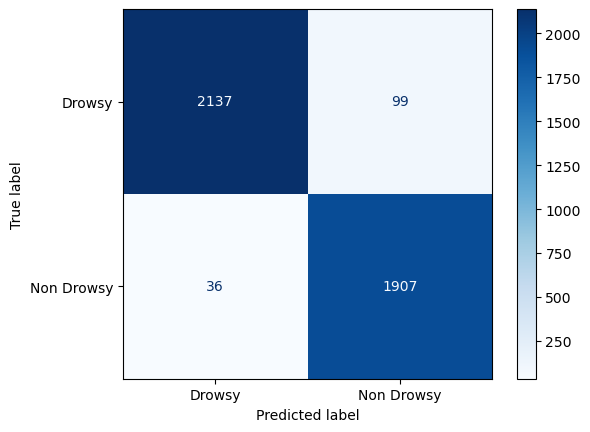

In [19]:
evaluate_and_confusion_matrix(model, test_dl, criterion, device)